In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler

# A Function for Plotting Decision Boundry 

In [12]:
def plot_boundry(predict_func, X, y, n_samples):
    X = X.reshape(n_samples,2)
    y = y.reshape(n_samples,)
    h = .05 
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    fig, ax = plt.subplots(figsize=(9,6))
    Z = predict_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.Wistia)
    ax.axis()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=80, edgecolor="black", cmap=plt.cm.coolwarm)
    plt.show()

# A Function for Splitting Data Into Train, CV, and Test

In [13]:
def train_cv_test_split(data, fracs=[0.7,0.15,0.15]):
    scaler = MinMaxScaler()
    features = data[0]
    target = data[1]
    features = scaler.fit_transform(features)
    df = pd.concat([pd.DataFrame(features),pd.Series(target)],axis=1)
    train_cv_df = df.sample(frac=sum(fracs[0:2]))
    train_df = train_cv_df.sample(frac = fracs[0]/sum(fracs[0:2]))
    cv_df = train_cv_df.drop(train_df.index)
    test_df = df.drop(train_cv_df.index)
    train_x, train_y = train_df.iloc[:, :-1].values, train_df.iloc[:,-1].values
    cv_x, cv_y = cv_df.iloc[:,:-1].values, cv_df.iloc[:,-1].values
    test_x, test_y = test_df.iloc[:,:-1].values, test_df.iloc[:,-1].values
    return(train_x,train_y,cv_x,cv_y,test_x,test_y)

# A Function for One Hot Encoder

In [14]:
def one_hot_encoder(labels, num_classes):
    C = tf.constant(num_classes)
    one_hot_matrix = tf.one_hot(labels, depth=C, axis=0)
    with tf.Session() as sess:
        one_hot = sess.run(one_hot_matrix)
    return one_hot.T

# Creating A Dataset

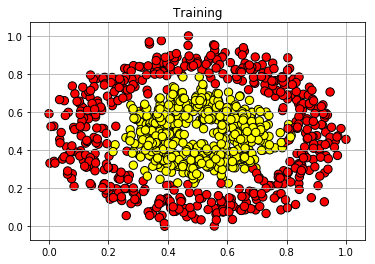

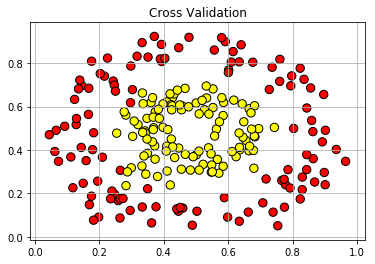

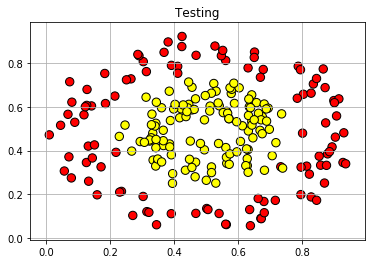

In [32]:
data = make_circles(n_samples=1500, noise=0.13, factor=0.4)
# data = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=2)
train_x,train_y,cv_x,cv_y,test_x,test_y = train_cv_test_split(data)

plt.scatter(train_x[:,0], train_x[:,1], c=train_y, s=70, edgecolor="black", cmap=plt.cm.autumn)
plt.grid(True)
plt.title("Training")
plt.show()

plt.scatter(cv_x[:,0], cv_x[:,1], c=cv_y, s=70, edgecolor="black", cmap=plt.cm.autumn)
plt.grid(True)
plt.title("Cross Validation")
plt.show()

plt.scatter(test_x[:,0], test_x[:,1], c=test_y, s=70, edgecolor="black", cmap=plt.cm.autumn)
plt.grid(True)
plt.title("Testing")
plt.show()

# A Function for Training NN

In [33]:
def train_binary_tf_nn(X,y,layer_dims, nn_learning_rate, nn_lambd, nn_num_epochs, class_weights):

    def tf_weight_generator(layer_num, layer_dims):
        initial_val = np.random.randn(layer_dims[layer_num], layer_dims[layer_num-1]) * np.sqrt(2/layer_dims[layer_num-1])
        return tf.Variable(initial_value=initial_val, dtype=tf.float32)

    def tf_bias_generator(layer_num, layer_dims):
        initial_val = np.zeros((layer_dims[layer_num],1))
        return tf.Variable(initial_value=initial_val, dtype=tf.float32)

    nn_m = X.shape[0]

    # defining placeholders
    xph = tf.placeholder(dtype=tf.float32, shape=(layer_dims[0],None))
    yph = tf.placeholder(dtype=tf.float32, shape=(1,None))

    # defining variables
    W = {'W'+str(i): tf_weight_generator(layer_num=i, layer_dims=layer_dims) for i in range(1,np.size(layer_dims))}
    b = {'b'+str(i): tf_bias_generator(layer_num=i, layer_dims=layer_dims) for i in range(1,np.size(layer_dims))}

    # defining logits and activation functions
    Z = {}
    A = {}
    for i in range(1,np.size(layer_dims)):
        if i==1:
            Z["Z"+str(i)] = tf.add(tf.matmul(W["W"+str(i)],xph),b["b"+str(i)])
            A["A"+str(i)] = tf.nn.relu(Z["Z"+str(i)])

        elif i==np.size(layer_dims)-1:
            Z["Z"+str(i)] = tf.add(tf.matmul(W["W"+str(i)],A["A"+str(i-1)]),b["b"+str(i)])
            A["A"+str(i)] = tf.nn.sigmoid(Z["Z"+str(i)])

        else:
            Z["Z"+str(i)] = tf.add(tf.matmul(W["W"+str(i)],A["A"+str(i-1)]),b["b"+str(i)])
            A["A"+str(i)] = tf.nn.relu(Z["Z"+str(i)]) 

    # defining cost
    reg_cost = (nn_lambd/(2*nn_m))*sum([tf.reduce_sum(W["W"+str(i)]**2) for i in range(1,np.size(layer_dims))])

    nn_cost = tf.reduce_sum(tf.add(class_weights[0]*tf.multiply(yph,tf.log(A["A"+str(np.size(layer_dims)-1)])),
                                   class_weights[1]*tf.multiply((1-yph),tf.log(1-A["A"+str(np.size(layer_dims)-1)]))))/(-nn_m)\
    + reg_cost

    # defining optimizer 
    nn_optimizer = tf.train.GradientDescentOptimizer(learning_rate=nn_learning_rate).minimize(nn_cost)
    
    # Starting and running session
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tot_nn_cost = []
        for epoch in range(nn_num_epochs):
            _, nn_c = sess.run([nn_optimizer, nn_cost], feed_dict={xph: X.T, yph: y.T.reshape(1,nn_m)})
            tot_nn_cost.append(nn_c)

        print("Optimization Finished!")
        variables = []
        for i in range(1,np.size(layer_dims)):
            variables.append(W['W'+str(i)])
            variables.append(b['b'+str(i)])
        params = sess.run(variables)

    print("")
    print("cost plot:")
    plt.plot(tot_nn_cost,color="black", linewidth=3)
    plt.grid(True)
    plt.show()
    return params

# A Function for Prediction

In [34]:
# defining prediction function
def nn_tf_LR(x,layer_dims,variables):
    weights = [tf.constant(variables[i]) for i in range(0,np.size(variables),2)]
    biases = [tf.constant(variables[i]) for i in range(1,np.size(variables),2)]
    x_ph = tf.placeholder(dtype=tf.float32, shape=(layer_dims[0],x.shape[0]))
    A_ = {}
    for i in range(1,np.size(layer_dims)):
        if i==1:
            A_["A"+str(i)] = tf.nn.relu(tf.add(tf.matmul(weights[i-1],x_ph),biases[i-1]))

        elif i==np.size(layer_dims)-1:
            A_["A"+str(i)] = tf.nn.sigmoid(tf.add(tf.matmul(weights[i-1],A_["A"+str(i-1)]),biases[i-1]))

        else:
            A_["A"+str(i)] = tf.nn.relu(tf.add(tf.matmul(weights[i-1],A_["A"+str(i-1)]),biases[i-1])) 
            
    yhat = tf.round(A_["A"+str(np.size(layer_dims)-1)])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        return (sess.run(yhat, feed_dict={x_ph:x.T}))

# Demonstrating the Performance of the Model

Optimization Finished!

cost plot:


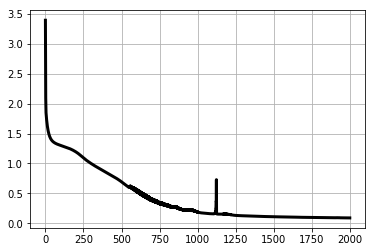

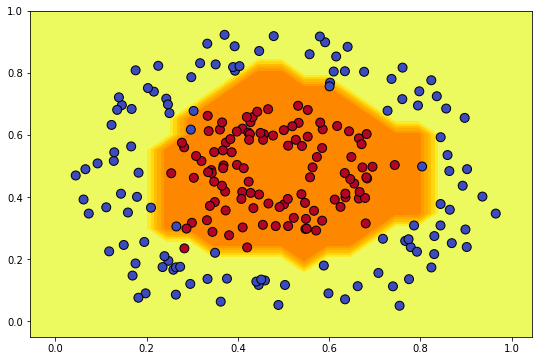

In [37]:
layer_dims = [2,6,5,4,1]
nn_learning_rate=0.05
nn_lambd=0.1
nn_num_epochs=2000
class_weights=[5,1]
params = train_binary_tf_nn(train_x,train_y,layer_dims, nn_learning_rate, nn_lambd, nn_num_epochs, class_weights)
plot_boundry(lambda x: nn_tf_LR(x,layer_dims,params), cv_x, cv_y, n_samples=cv_x.shape[0])